# Homework 2 - ECE 760 - Dario Placencio

### A Simplified Decision Tree
You are to implement a decision-tree learner for classification. To simplify your work, this will not be a general-purpose decision tree. Instead, your program can assume that:

- Each item has two continuous features (x1, x2) and a binary class label (y).
- Data files are in plaintext with one labeled item per line, separated by whitespace, as follows:

  - x11 x12 y1
  - ...
  - xn1 xn2 yn

Your program should implement a decision tree learner according to the following guidelines:

- Candidate splits (j, c) for numeric features should use a threshold c in feature dimension j in the form of xj ≥ c.
- c should be on values of that dimension present in the training data; i.e., the threshold is on training points, not in between training points. You may enumerate all features, and for each feature, use all possible values for that dimension.
- You may skip those candidate splits with zero split information (i.e., the entropy of the split) and continue the enumeration.
- The left branch of such a split is the "then" branch, and the right branch is "else."
- Splits should be chosen using information gain ratio. If there is a tie, you may break it arbitrarily.
- The stopping criteria (for making a node into a leaf) are that:
  - The node is empty, or
  - All splits have zero gain ratio (if the entropy of the split is non-zero), or
  - The entropy of any candidate split is zero.

To simplify, whenever there is no majority class in a leaf, let it predict y = 1.

### Program


Before building the decision tree, the tools that will be used for the calculations are defined. These are: entropy, information gain, information gain ratio, split information, and the best split.

In [1]:
# Importing libraries
import math

#### Calculating Entropy

For a set 's'of binary classification entropy will be calculated as follows:

$\text{entropy}(S) = -p_+ \log_2(p_+) - p_- \log_2(p_-)$

where $p_+$ is the probability of a positive class and $p_-$ is the probability of a negative class on the label (y).

In [2]:
# Calculate entropy

def entropy(S):
    if len(S) == 0: 
        return 0
    p_plus = sum(1 for _, _, y in S if y == 1) / len(S)
    p_minus = sum(1 for _, _, y in S if y == 0) / len(S)
    if p_plus == 0 or p_minus == 0: 
        return 0
    return -p_plus * math.log2(p_plus) - p_minus * math.log2(p_minus)

#### Calculating Information Gain and Gain Ratio

Information Gain is the difference in entropy from before to after the split:

$\text{Gain}(S, A) = \text{entropy}(S) - \sum_{t \in \{true, false\}} \frac{|S_t|}{|S|} \text{entropy}(S_t)$

where $S_t$ is the subset of examples for which attribute $A$ is true.

In [3]:
# Calculate information gain

def information_gain(S, A):
    return entropy(S) - sum((len(part) / len(S)) * entropy(part) for part in A)

Gain Ratio is the ratio of Information Gain to the intrinsic information of the split:

$\text{GainRatio}(S, A) = \frac{\text{Gain}(S, A)}{\text{SplitInfo}(S, A)}$

where $\text{SplitInfo}(S, A) = -\sum_{t \in \{true, false\}} \frac{|S_t|}{|S|} \log_2 \frac{|S_t|}{|S|}$ represents the potential information generated by splitting the dataset S into A partitions.

In [4]:
# Calculating split information
def split_info(S, A):
    return -sum((len(part) / len(S)) * math.log2(len(part) / len(S)) if len(part) > 0 else 0 for part in A)

In [5]:
# Putting it all together
def gain_ratio(S, A):
    split_info_val = split_info(S, A)
    if split_info_val == 0:
        return 0
    return information_gain(S, A) / split_info_val

#### Best Split

Best split is the split that maximizes the information gain ratio, considering all possible splits for each feature, and the use of the threshold c in feature dimension j in the form of xj ≥ c.

In [6]:
def best_split(S):
    best_gr = -1
    best_split = None

    for feature in [0, 1]:
        for _, value, _ in S:
            # Split using threshold
            S1 = [(x1, x2, y) for x1, x2, y in S if (x1 if feature == 0 else x2) >= value]
            S2 = [(x1, x2, y) for x1, x2, y in S if (x1 if feature == 0 else x2) < value]
            
            gr = gain_ratio(S, [S1, S2])

            if gr > best_gr:
                best_gr = gr
                best_split = (feature, value)

    return best_split if best_gr > 0 else None

#### Building the Decision Tree

Through a recursive process, the decision tree is built. The process is as follows:

In [7]:
class Node:
    def __init__(self):
        self.feature = None
        self.threshold = None
        self.left = None
        self.right = None
        self.label = None

def build_tree(S):
    node = Node()

    # Stopping criteria
    if not S or all(entropy([(x1, x2, y) for x1, x2, y in S if (x1 if feature == 0 else x2) >= value]) == 0 for feature in [0, 1] for _, value, _ in S):
        node.label = 1 if sum(y for _, _, y in S) >= len(S) / 2 else 0
        return node

    split = best_split(S)
    if not split:
        node.label = 1
        return node

    feature, threshold = split
    node.feature = feature
    node.threshold = threshold

    S1 = [(x1, x2, y) for x1, x2, y in S if (x1 if feature == 0 else x2) >= threshold]
    S2 = [(x1, x2, y) for x1, x2, y in S if (x1 if feature == 0 else x2) < threshold]

    node.left = build_tree(S1)
    node.right = build_tree(S2)

    return node

#### Building Loader

In [8]:
def load_data(filename):
    with open(filename, 'r') as f:
        data = [tuple(map(float, line.split()[:2])) + (int(line.split()[2]),) for line in f]
    return data

### Questions

1. (Our algorithm stops at pure labels) [10 pts] If a node is not empty but contains training items with the same label, why is it guaranteed to become a leaf?  Explain. You may assume that the feature values of these items are not all the same. 

If a node contains training items with the same label, then the entropy of the node is \(0\). This is because entropy measures the amount of uncertainty or randomness in a set. If all the labels are the same, there is no uncertainty. The formula for entropy is:

$\text{entropy}(S) = -p_+ \log_2(p_+) - p_- \log_2(p_-)$

Where:

- \( p_+ \) is the proportion of positive examples in \( S \).
- \( p_- \) is the proportion of negative examples in \( S \).


In the case where all examples have the same label, one of the proportions (either \( p_+ \) or \( p_- \)) will be \(1\), and the other will be \(0\). This results in an entropy of \(0\).
Given our decision tree's stopping criterion, if the entropy of a node is \(0\), we make that node a leaf. This is because there is no benefit to splitting a node with zero entropy further: we already have a perfectly accurate classification for the training items in that node.

2. (Our algorithm is greedy)  [10 pts] Handcraft a small training set where both classes are present but the algorithm refuses to split; instead it makes the root a leaf and stop;
Importantly, if we were to manually force a split, the algorithm will happily continue splitting the data set further and produce a deeper tree with zero training error.
You should (1) plot your training set, (2) explain why.  Hint: you don't need more than a handful of items.

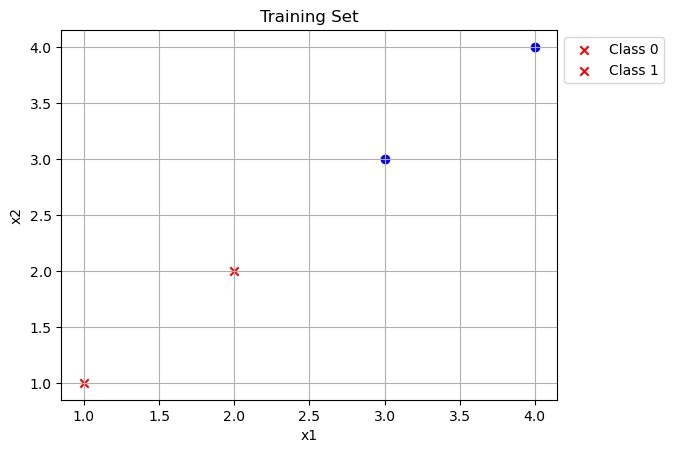

In [9]:
# Crafting a small training set

import matplotlib.pyplot as plt

# Sample data
data = [
    (1, 1, 0),
    (2, 2, 0),
    (3, 3, 1),
    (4, 4, 1)
]

# Plotting the training set
for x, y, label in data:
    if label == 0:
        plt.scatter(x, y, color='red', marker='x')
    else:
        plt.scatter(x, y, color='blue', marker='o')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Set')
plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
plt.grid(True)
plt.show()

In the plotted training set, we have the two classes (0 and 1). Initially, if our algorithm tries to split based on the best information gain (or gain ratio), it would find that there's no effective split to separate the classes at the root since they're intertwined. Thus, the algorithm might refuse to split and decide to make the root a leaf.

However, if we manually force a split (say, x1 < 3), then the algorithm can further split the data to produce a deeper tree. For the left child node with data points {(1,1,0), (2,2,0)}, a further split on x1 can perfectly separate these two points, and similarly for the right child node with data points {(3,3,1), (4,4,1)}.

This example illustrates that the greedy approach of decision trees, which relies solely on metrics like information gain or gain ratio, may not always find the optimal tree, especially when the decision boundaries are not straightforward.

3. (Information gain ratio exercise)  [10 pts] Use the training set Druns.txt.  For the root node, list all candidate cuts and their information gain ratio. If the entropy of the candidate split is zero, please list its mutual information (i.e. information gain). Hint: to get $\log_2(x)$ when your programming language may be using a different base, use \verb|log(x)/log(2)|. Also, please follow the split rule in the first section.


In [10]:
# Read Druns.txt
with open('Druns.txt', 'r') as file:
    data = [tuple(map(float, line.split())) for line in file]

In [11]:
# Unique values for features
feature_values = {
    0: sorted(set([x1 for x1, x2, y in data])),
    1: sorted(set([x2 for x1, x2, y in data]))
}

In [12]:
# Compute the information gain ratio for each candidate cut
results = []

for feature_index, values in feature_values.items():
    for value in values:
        S_left = [(x1, x2, y) for x1, x2, y in data if (x1 if feature_index == 0 else x2) >= value]
        S_right = [(x1, x2, y) for x1, x2, y in data if (x1 if feature_index == 0 else x2) < value]

        if len(S_left) == 0 or len(S_right) == 0:  # Skip if any split has no data
            continue

        GR = gain_ratio(data, (S_left, S_right))

        # If entropy is zero, list mutual information
        if entropy(S_left) == 0 or entropy(S_right) == 0:
            results.append((feature_index, value, 'IG', information_gain(data, (S_left, S_right))))
            continue

        results.append((feature_index, value, 'GR', GR))

# Output results
for feature_index, value, metric, result in results:
    print(f"Feature: {feature_index + 1}, Value: {value}, Metric: {metric}, Value: {result:.4f}")

Feature: 1, Value: 0.1, Metric: IG, Value: 0.0442
Feature: 2, Value: -1.0, Metric: IG, Value: 0.0442
Feature: 2, Value: 0.0, Metric: GR, Value: 0.0560
Feature: 2, Value: 1.0, Metric: GR, Value: 0.0058
Feature: 2, Value: 2.0, Metric: GR, Value: 0.0011
Feature: 2, Value: 3.0, Metric: GR, Value: 0.0164
Feature: 2, Value: 4.0, Metric: GR, Value: 0.0497
Feature: 2, Value: 5.0, Metric: GR, Value: 0.1112
Feature: 2, Value: 6.0, Metric: GR, Value: 0.2361
Feature: 2, Value: 7.0, Metric: GR, Value: 0.0560
Feature: 2, Value: 8.0, Metric: IG, Value: 0.1891


For the root node, considering the candidate cuts on the dataset Druns.txt, we can observe the following Information Gain Ratios (GR) and Information Gains (IG) for each threshold value:
For Feature 1 (x1):

- For a threshold of 0.1, the Information Gain (IG) is 0.04420

For Feature 2 (x2):

- For a threshold of −1.0, the Information Gain (IG) is 0.04420
- For a threshold of 0.0, the Gain Ratio (GR) is 0.05600
- For a threshold of 1.0, the Gain Ratio (GR) is 0.00580
- For a threshold of 2.0, the Gain Ratio (GR) is 0.00110
- For a threshold of 3.0, the Gain Ratio (GR) is 0.01640
- For a threshold of 4.0, the Gain Ratio (GR) is 0.04970
- For a threshold of 5.0, the Gain Ratio (GR) is 0.11120
- For a threshold of 6.0, the Gain Ratio (GR) is 0.23610
- For a threshold of 7.0, the Gain Ratio (GR) is 0.05600
- For a threshold of 8.0, the Information Gain (IG) is 0.18910

From the above results, we observe that the highest Gain Ratio (GR) is 0.23610 for a threshold of 6.0 on Feature 2. This would be the most promising candidate cut for the root node. It's important to note the instances where the Gain Ratio (GR) is not computed due to the split entropy being zero, and instead, the Information Gain (IG) was calculated.

4. (The king of interpretability)  [10 pts] Decision tree is not the most accurate classifier in general.  However, it persists.  This is largely due to its rumored interpretability: a data scientist can easily explain a tree to a non-data scientist.  Build a tree from D3leaves.txt.  Then manually convert your tree to a set of logic rules.  Show the tree\footnote{When we say show the tree, we mean either the standard computer science tree view, or some crude plaintext representation of the tree -- as long as you explain the format.  When we say visualize the tree, we mean a plot in the 2D $x$ space that shows how the tree will classify any points.} and the rules.


In [13]:
# Read D3leaves.txt
with open('D3leaves.txt', 'r') as file:
    df4 = [tuple(map(float, line.split())) for line in file]

In [14]:
# Build the tree
root = build_tree(df4)

In [15]:
# Create a new function to visualize the tree
def print_tree(node, indent=""):
    if node.label is not None:
        print(indent + str(node.label))
        return
    print(indent + f'x{node.feature + 1} >= {node.threshold}')
    if node.left is not None:
        print_tree(node.left, indent + '|   ')
    if node.right is not None:
        print_tree(node.right, indent + '|   ')
        
# Print the tree    
print_tree(root)

x1 >= 2.0
|   1
|   x2 >= 3.0
|   |   1
|   |   0


Rules of the Tree:

- IF $(x_1 \geq 2.0)$ THEN class = 1
- IF $(x_1 < 2.0)$ AND $(x_2 \geq 3.0)$ THEN class = 1
- IF $(x_1 < 2.0)$ AND $(x_2 < 3.0)$ THEN class = 0

5. (Or is it?)  [10 pts] For this question only, make sure you DO NOT VISUALIZE the data sets or plot your tree's decision boundary in the 2D $x$ space.  If your code does that, turn it off before proceeding.  This is because you want to see your own reaction when trying to interpret a tree.  You will get points no matter what your interpretation is.
And we will ask you to visualize them in the next question anyway.

- Build a decision tree on D1.txt. Show it to us in any format (e.g. could be a standard binary tree with
nodes and arrows, and denote the rule at each leaf node; or as simple as plaintext output where each
line represents a node with appropriate line number pointers to child nodes; whatever is convenient
for you). Again, do not visualize the data set or the tree in the x input space. In real tasks you will not
be able to visualize the whole high dimensional input space anyway, so we don’t want you to “cheat”
here.

In [16]:
# Read D1.txt
with open('D1.txt', 'r') as file:
    df1 = [tuple(map(float, line.split())) for line in file]

In [17]:
# Build the tree
root = build_tree(df1)

In [18]:
# Print the tree
print_tree(root)

x2 >= 0.201829
|   1
|   0


- Look at your tree in the above format (remember, you should not visualize the 2D dataset or your
tree’s decision boundary) and try to interpret the decision boundary in human understandable English.

From the decision tree built on D1.txt, only a single split is made, with the rule being:

- If X2 is greater than or equal to 0.201829, then the class is 1.
- If X2 is less than 0.201829, then the class is 0.

Regarding the decision boundary is difficult to interpret the total lack of knowledge of the magnitude of the features. However, I'm integred of why ended being a decimal number the threshold for the split.

- Build a decision tree on D2.txt. Show it to us.

In [19]:
# Read D2.txt
with open('D2.txt', 'r') as file:
    df2 = [tuple(map(float, line.split())) for line in file]

# Build the tree
root2 = build_tree(df2)

In [20]:
# Print the tree
print_tree(root2)

x1 >= 0.532684
|   x2 >= 0.228007
|   |   x2 >= 0.424906
|   |   |   1
|   |   |   x2 >= 0.421367
|   |   |   |   0
|   |   |   |   x2 >= 0.234851
|   |   |   |   |   x2 >= 0.410302
|   |   |   |   |   |   1
|   |   |   |   |   |   x2 >= 0.405307
|   |   |   |   |   |   |   0
|   |   |   |   |   |   |   x2 >= 0.383738
|   |   |   |   |   |   |   |   1
|   |   |   |   |   |   |   |   x2 >= 0.380214
|   |   |   |   |   |   |   |   |   0
|   |   |   |   |   |   |   |   |   x2 >= 0.367848
|   |   |   |   |   |   |   |   |   |   1
|   |   |   |   |   |   |   |   |   |   x2 >= 0.365809
|   |   |   |   |   |   |   |   |   |   |   0
|   |   |   |   |   |   |   |   |   |   |   x2 >= 0.357304
|   |   |   |   |   |   |   |   |   |   |   |   1
|   |   |   |   |   |   |   |   |   |   |   |   x2 >= 0.351951
|   |   |   |   |   |   |   |   |   |   |   |   |   0
|   |   |   |   |   |   |   |   |   |   |   |   |   x2 >= 0.341365
|   |   |   |   |   |   |   |   |   |   |   |   |   |   1
|   |   |   |   

- Try to interpret your D2 decision tree. Is it easy or possible to do so without visualization?

So, this case is the totally of oposit, with many splits being made. From here I could suggest that the tree is more complex, and sensitive to the features, hence the need for more splits. However, I'm not sure if this is the case, without visualizing the data, so it's difficult to interpret the decision tree.

6. (Hypothesis space) [10 pts] For D1.txt and D2.txt, do the following separately:


In [21]:
import numpy as np

In [22]:
# Define predict function
def predict(node, x1, x2):
    if node.label is not None:
        return node.label
    if (x1 if node.feature == 0 else x2) >= node.threshold:
        return predict(node.left, x1, x2)
    else:
        return predict(node.right, x1, x2)

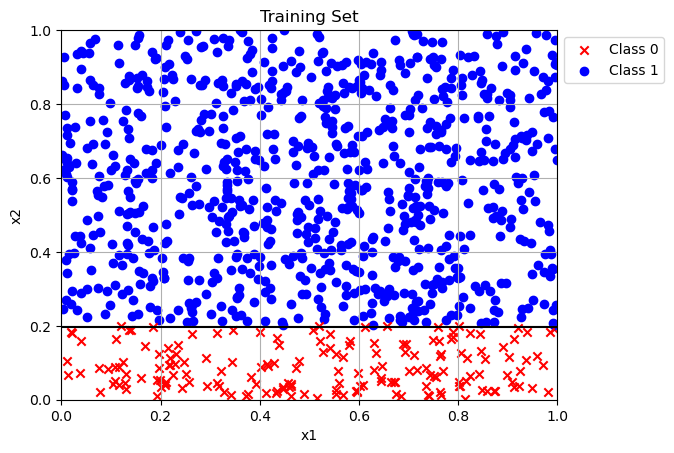

In [23]:
# Produce a scatter plot of the data set.
for x, y, label in df1:
    if label == 0:
        plt.scatter(x, y, color='red', marker='x')
    else:
        plt.scatter(x, y, color='blue', marker='o')
      
# Plot the decision boundary
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([predict(root, x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z, [0.5], colors='black')
  
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Set')
plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
plt.grid(True)
plt.show();

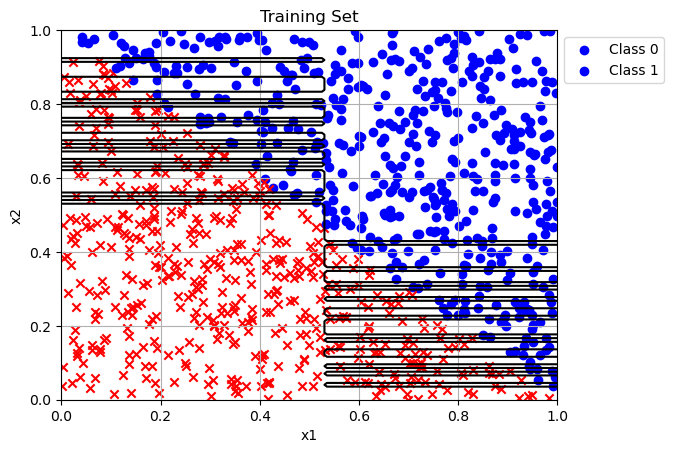

In [24]:
# Produce a scatter plot of the data set.
for x, y, label in df2:
    if label == 0:
        plt.scatter(x, y, color='red', marker='x')
    else:
        plt.scatter(x, y, color='blue', marker='o')

# Plot the decision boundary
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.array([predict(root2, x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)
plt.contour(X, Y, Z, [0.5], colors='black')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Training Set')
plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
plt.grid(True)
plt.show();

It can be observed the difference in complexity for D2 compared to D1, the distribution of the labels on D1 makes the tree quite simple, considering the strong effect of X2 on the label. On the case of D2 is the oposit, the distribution of the labels is more complex, and the effect of X1 and X2 is not as strong as in D1, hence the need for more splits.  

7. (Learning curve)  [20 pts] We provide a data set Dbig.txt with 10000 labeled items.  Caution: Dbig.txt is sorted.

In [25]:
# Read Dbig.txt
with open('Dbig.txt', 'r') as file:
    dbig = [tuple(map(float, line.split())) for line in file]

- You will randomly split Dbig.txt into a candidate training set of 8192 items and a test set (the rest).  Do this by generating a random permutation, and split at 8192.

In [26]:
# Randomly split Dbig.txt into two sets: Dtrain.txt (8192 items) and Dtest.txt (rest)
np.random.seed(0)   
np.random.shuffle(dbig)
Dtrain = dbig[:8192]
Dtest = dbig[8192:]

- Generate a sequence of five nested training sets $D_{32} \subset D_{128} \subset D_{512} \subset D_{2048} \subset D_{8192}$ from the candidate training set.  The subscript $n$ in $D_n$ denotes training set size.  The easiest way is to take the first $n$ items from the (same) permutation above.  This sequence simulates the real world situation where you obtain more and more training data.
  

In [28]:
# Five nested training sets of size 32, 128, 512, 2048, and 8192
np.random.seed(0)
np.random.shuffle(Dtrain)
Dtrain32 = Dtrain[:32]
Dtrain128 = Dtrain[:128]
Dtrain512 = Dtrain[:512]
Dtrain2048 = Dtrain[:2048]
Dtrain8192 = Dtrain[:8192]

- For each $D_n$ above, train a decision tree.  Measure its test set error $err_n$.  Show three things in your answer: (1) List $n$, number of nodes in that tree, $err_n$. (2) Plot $n$ vs. $err_n$.  This is known as a learning curve (a single plot). (3) Visualize your decision trees' decision boundary (five plots). \\
 

In [29]:
# Traing a decision tree on each of the five training sets
root32 = build_tree(Dtrain32)
root128 = build_tree(Dtrain128)
root512 = build_tree(Dtrain512)
root2048 = build_tree(Dtrain2048)
root8192 = build_tree(Dtrain8192)

In [30]:
# Measure the test error of each tree
def test_error(node, data):
    return sum(predict(node, x1, x2) != y for x1, x2, y in data) / len(data)

print(f"Test error for Dtrain32: {test_error(root32, Dtest):.4f}")
print(f"Test error for Dtrain128: {test_error(root128, Dtest):.4f}")
print(f"Test error for Dtrain512: {test_error(root512, Dtest):.4f}")
print(f"Test error for Dtrain2048: {test_error(root2048, Dtest):.4f}")
print(f"Test error for Dtrain8192: {test_error(root8192, Dtest):.4f}")

Test error for Dtrain32: 0.1538
Test error for Dtrain128: 0.1173
Test error for Dtrain512: 0.0846
Test error for Dtrain2048: 0.0918
Test error for Dtrain8192: 0.0874


In [31]:
# List the number of nodes on each tree
def count_nodes(node):
    if node.label is not None:
        return 1
    return 1 + count_nodes(node.left) + count_nodes(node.right)

print(f"Number of nodes for Dtrain32: {count_nodes(root32)}")
print(f"Number of nodes for Dtrain128: {count_nodes(root128)}")
print(f"Number of nodes for Dtrain512: {count_nodes(root512)}")
print(f"Number of nodes for Dtrain2048: {count_nodes(root2048)}")
print(f"Number of nodes for Dtrain8192: {count_nodes(root8192)}")

Number of nodes for Dtrain32: 19
Number of nodes for Dtrain128: 43
Number of nodes for Dtrain512: 123
Number of nodes for Dtrain2048: 341
Number of nodes for Dtrain8192: 1597


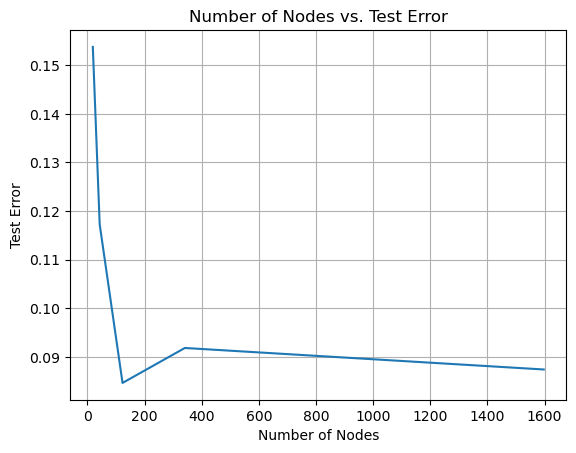

In [32]:
# Plot number of nodes vs. test error (Learning Curve)
nodes = [count_nodes(root32), count_nodes(root128), count_nodes(root512), count_nodes(root2048), count_nodes(root8192)]
errors = [test_error(root32, Dtest), test_error(root128, Dtest), test_error(root512, Dtest), test_error(root2048, Dtest), test_error(root8192, Dtest)]

plt.plot(nodes, errors)
plt.xlabel('Number of Nodes')
plt.ylabel('Test Error')
plt.title('Number of Nodes vs. Test Error')
plt.grid(True)
plt.show();

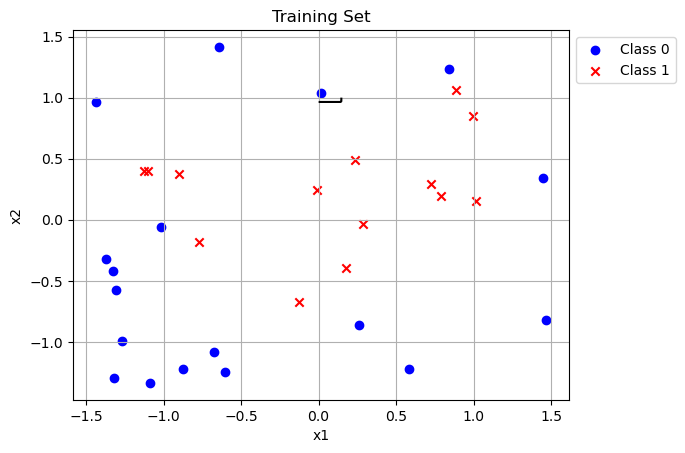

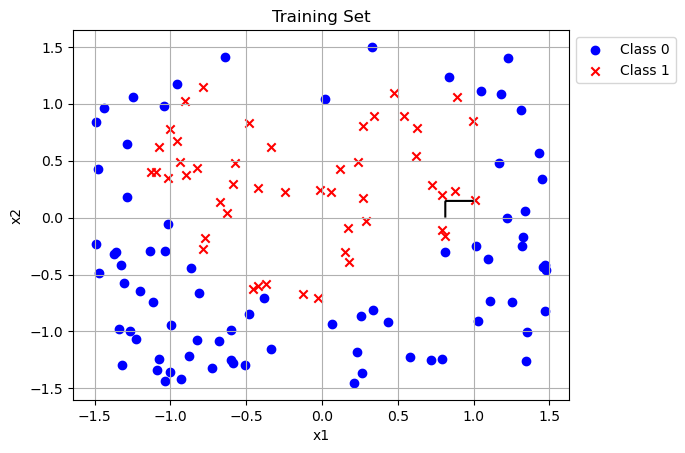

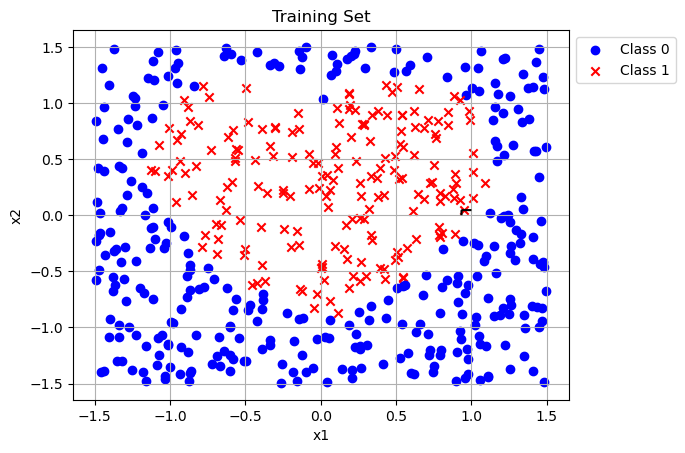

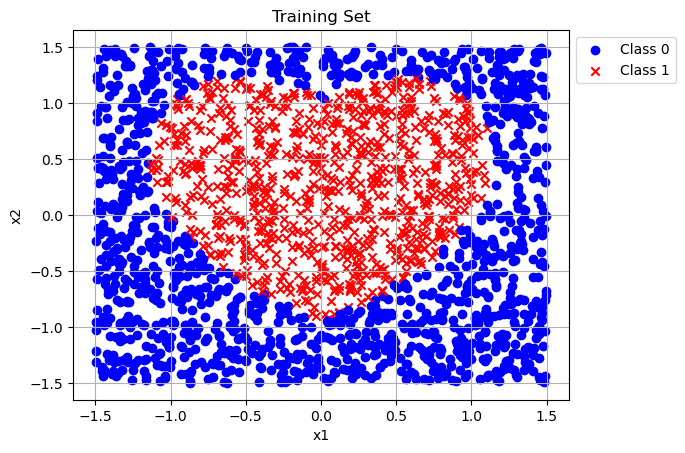

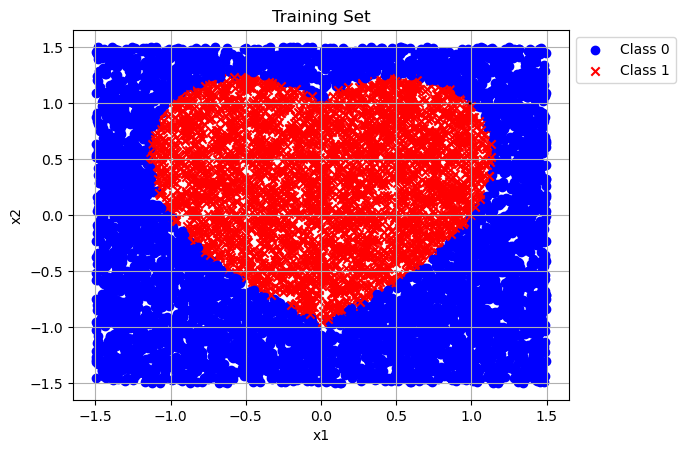

In [33]:
# Visualize each tree decision boundary
def plot_tree(node, data):
    for x, y, label in data:
        if label == 0:
            plt.scatter(x, y, color='red', marker='x')
        else:
            plt.scatter(x, y, color='blue', marker='o')
    
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([predict(node, x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)
    plt.contour(X, Y, Z, [0.5], colors='black')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Training Set')
    plt.legend(["Class 0", "Class 1"], loc ="upper left", bbox_to_anchor =(1, 1))
    plt.grid(True)
    plt.show();
    
plot_tree(root32, Dtrain32)
plot_tree(root128, Dtrain128)
plot_tree(root512, Dtrain512)
plot_tree(root2048, Dtrain2048)
plot_tree(root8192, Dtrain8192)

Cute detail.

### 3. sklearn [10 pts]

Learn to use sklearn (\url{https://scikit-learn.org/stable/}).

Use sklearn.tree.DecisionTreeClassifier to produce trees for datasets $D_{32}, D_{128}, D_{512}, D_{2048}, D_{8192}$.  Show two things in your answer: (1) List $n$, number of nodes in that tree, $err_n$. (2) Plot $n$ vs. $err_n$.

In [34]:
# import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [35]:
# Train decision trees using sklearn on each of the five training sets
clf32 = DecisionTreeClassifier()
clf32.fit([x[:2] for x in Dtrain32], [x[2] for x in Dtrain32])

clf128 = DecisionTreeClassifier()
clf128.fit([x[:2] for x in Dtrain128], [x[2] for x in Dtrain128])

clf512 = DecisionTreeClassifier()
clf512.fit([x[:2] for x in Dtrain512], [x[2] for x in Dtrain512])

clf2048 = DecisionTreeClassifier()
clf2048.fit([x[:2] for x in Dtrain2048], [x[2] for x in Dtrain2048])

clf8192 = DecisionTreeClassifier()
clf8192.fit([x[:2] for x in Dtrain8192], [x[2] for x in Dtrain8192])

DecisionTreeClassifier()

In [36]:
# Measure the test error of each tree   

print(f"Test error for Dtrain32: {1 - accuracy_score([x[2] for x in Dtest], clf32.predict([x[:2] for x in Dtest])):.4f}")
print(f"Test error for Dtrain128: {1 - accuracy_score([x[2] for x in Dtest], clf128.predict([x[:2] for x in Dtest])):.4f}")
print(f"Test error for Dtrain512: {1 - accuracy_score([x[2] for x in Dtest], clf512.predict([x[:2] for x in Dtest])):.4f}")
print(f"Test error for Dtrain2048: {1 - accuracy_score([x[2] for x in Dtest], clf2048.predict([x[:2] for x in Dtest])):.4f}")
print(f"Test error for Dtrain8192: {1 - accuracy_score([x[2] for x in Dtest], clf8192.predict([x[:2] for x in Dtest])):.4f}")

Test error for Dtrain32: 0.2063
Test error for Dtrain128: 0.0791
Test error for Dtrain512: 0.0503
Test error for Dtrain2048: 0.0227
Test error for Dtrain8192: 0.0100


(1) List $n$, number of nodes in that tree, $err_n$.

In [37]:
# List the number of nodes on each tree
print(f"Number of nodes for Dtrain32: {clf32.tree_.node_count}")
print(f"Number of nodes for Dtrain128: {clf128.tree_.node_count}")
print(f"Number of nodes for Dtrain512: {clf512.tree_.node_count}")
print(f"Number of nodes for Dtrain2048: {clf2048.tree_.node_count}")
print(f"Number of nodes for Dtrain8192: {clf8192.tree_.node_count}")

Number of nodes for Dtrain32: 19
Number of nodes for Dtrain128: 23
Number of nodes for Dtrain512: 59
Number of nodes for Dtrain2048: 95
Number of nodes for Dtrain8192: 249


(2) Plot $n$ vs. $err_n$.

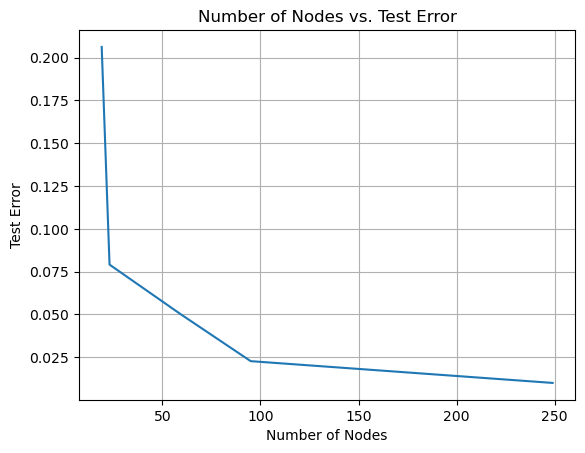

In [38]:
# Plot number of nodes vs. test error (Learning Curve)
nodes = [clf32.tree_.node_count, clf128.tree_.node_count, clf512.tree_.node_count, clf2048.tree_.node_count, clf8192.tree_.node_count]

errors = [1 - accuracy_score([x[2] for x in Dtest], clf32.predict([x[:2] for x in Dtest])),
            1 - accuracy_score([x[2] for x in Dtest], clf128.predict([x[:2] for x in Dtest])),
            1 - accuracy_score([x[2] for x in Dtest], clf512.predict([x[:2] for x in Dtest])),
            1 - accuracy_score([x[2] for x in Dtest], clf2048.predict([x[:2] for x in Dtest])),
            1 - accuracy_score([x[2] for x in Dtest], clf8192.predict([x[:2] for x in Dtest]))]

plt.plot(nodes, errors)
plt.xlabel('Number of Nodes')
plt.ylabel('Test Error')
plt.title('Number of Nodes vs. Test Error')
plt.grid(True)
plt.show();

### 4. Lagrange Interpolation [10 pts]

Fix some interval $[a, b]$ and sample $n = 100$ points $x$ from this interval uniformly. Use these to build a training set consisting of $n$ pairs $(x, y)$ by setting function $y = sin(x)$. \\

In [1]:
from scipy.interpolate import lagrange
from sklearn.metrics import mean_squared_error

In [3]:
import numpy as np

In [4]:
# Generate training data
a, b = 0, 2 * np.pi
n = 100
x_train = np.linspace(a, b, n)
y_train = np.sin(x_train)

Build a model f by using Lagrange interpolation, check more details in https://en.wikipedia.org/wiki/Lagrange
polynomial and https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html.

In [5]:
# Generate model using Lagrange interpolation
f = lagrange(x_train, y_train)

In [6]:
# Generate test data
x_test = np.linspace(a, b, 100)
y_test = np.sin(x_test)
y_pred = f(x_test)

In [7]:
# Compute training and test error
train_error = mean_squared_error(y_train, f(x_train))
test_error = mean_squared_error(y_test, y_pred)

In [62]:
# Print the errors
print(f"Training error: {train_error:.4f}")
print(f"Test error: {test_error:.4f}")

Training error: 2579203191358861655741281668817037777986992106192360153705231221707604839904936071906617712583085713141976236162257245029539615892331036672.0000
Test error: 2579203191358861655741281668817037777986992106192360153705231221707604839904936071906617712583085713141976236162257245029539615892331036672.0000


In [11]:
# Calculate difference between training and test error
print(f"Difference: {abs(train_error - test_error):.4f}")

Difference: 0.0000


From the test errors it can be observed an incredible size of the magnitude of the errors, almost astronomaically large, but it might be the  nature of the interpolation method with a big number of points.

More importantly, the values between train and test are the same.

In [8]:
# Adding noise to x_train
std_devs = [0.05, 0.1, 0.2, 0.5]
errors = []
for std_dev in std_devs:
    noise = np.random.normal(0, std_dev, n)
    x_train_noisy = x_train + noise
    f_noisy = lagrange(x_train_noisy, y_train)
    test_error_noisy = mean_squared_error(y_test, f_noisy(x_test))
    errors.append(test_error_noisy)

In [12]:
# Calculate difference between training and test error for each noise level
for std_dev, error in zip(std_devs, errors):
    print(f"Standard Deviation: {std_dev:.2f}, Test Error: {error:.4f}, Difference: {abs(train_error - error):.4f}")

Standard Deviation: 0.05, Test Error: 65904288593209099036690962356146528292795024539075172347144876849541672352542563436845621087339132386352866551538866939704553612136813690880.0000, Difference: 63325085401850236058837743106832292610977416367340732536630279699271628943340036816127420902133355022832469435946039999492589946197766045696.0000
Standard Deviation: 0.10, Test Error: 4220339251106148515784497158802086882168379804749177830423013005781121021130536588323834571062015798529732830915534223371057204348020831159320576.0000, Difference: 4220336671902957150543651318694519085244619095240831103718754109944585547428835808989746779013898728230943808196045562334556978766929531192213504.0000
Standard Deviation: 0.20, Test Error: 3848762948211680748434993459171096345270397063822291950711707759297885357171334550833182085912063485683100349466150054684732075009800551792640.0000, Difference: 384618374502032159988096172253438736236116638549346830503037012157812858279385246566916207164035631183784

The magnitudes are still very large, but this is based on the nature of the function, and the interpolation method. But now the values are different between train and test, and the relationship with the standard deviation is positive, more deviation, more error.